In [2]:
# Import necessary libraries
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import numpy as np
import os
from zipfile import ZipFile
import json
import matplotlib.image as mpimg

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')
# Install Kaggle
!pip install kaggle

# Load Kaggle credentials
kaggle_credentials = json.load(open("/content/drive/MyDrive/kaggle (2).json"))

os.environ['KAGGLE_USERNAME'] = kaggle_credentials["username"]
os.environ['KAGGLE_KEY'] = kaggle_credentials["key"]

# Download the dataset
!kaggle datasets download -d cristiancristancho/forest-fire-image-dataset

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Dataset URL: https://www.kaggle.com/datasets/cristiancristancho/forest-fire-image-dataset
License(s): GPL-2.0
100% 1.17G/1.17G [00:20<00:00, 82.2MB/s]
100% 1.17G/1.17G [00:20<00:00, 61.7MB/s]


Image Shape: (1080, 1920, 3)


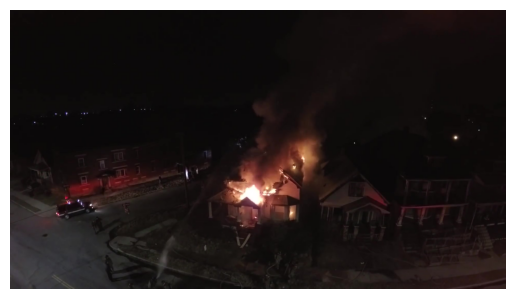

In [3]:
with ZipFile("/content/forest-fire-image-dataset.zip", 'r') as zip_ref:
    zip_ref.extractall()

# Visualize a sample image
image_path = '/content/FOREST_FIRE_DATASET/FIRE/00161.jpg'
img = mpimg.imread(image_path)
print("Image Shape:", img.shape)

plt.imshow(img)
plt.axis('off')  # Turn off axis numbers
plt.show()


In [4]:
from sklearn.model_selection import train_test_split
import shutil

# Paths to FIRE and NON_FIRE directories
fire_dir = '/content/FOREST_FIRE_DATASET/FIRE'
non_fire_dir = '/content/FOREST_FIRE_DATASET/NON_FIRE'

# Temporary directories for train and test splits
train_dir = '/content/Train_Data'
test_dir = '/content/Test_Data'

# Create necessary directories
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)
os.makedirs(os.path.join(train_dir, 'FIRE'), exist_ok=True)
os.makedirs(os.path.join(train_dir, 'NON_FIRE'), exist_ok=True)
os.makedirs(os.path.join(test_dir, 'FIRE'), exist_ok=True)
os.makedirs(os.path.join(test_dir, 'NON_FIRE'), exist_ok=True)

# Function to split and copy files
def split_dataset(source_dir, train_dest, test_dest, split_ratio=0.6):
    files = os.listdir(source_dir)
    train_files, test_files = train_test_split(files, test_size=1-split_ratio, random_state=42)
    for file in train_files:
        shutil.copy(os.path.join(source_dir, file), os.path.join(train_dest, file))
    for file in test_files:
        shutil.copy(os.path.join(source_dir, file), os.path.join(test_dest, file))

# Split the datasets for FIRE and NON_FIRE
split_dataset(fire_dir, os.path.join(train_dir, 'FIRE'), os.path.join(test_dir, 'FIRE'))
split_dataset(non_fire_dir, os.path.join(train_dir, 'NON_FIRE'), os.path.join(test_dir, 'NON_FIRE'))

In [5]:
from tensorflow.keras.utils import image_dataset_from_directory

# Paths for train and test data
train_dataset = image_dataset_from_directory(
    train_dir,
    label_mode='binary',
    image_size=(299, 299),
    batch_size=32
)

test_dataset = image_dataset_from_directory(
    test_dir,
    label_mode='binary',
    image_size=(299, 299),
    batch_size=32
)

# Shuffle and prefetch for efficiency
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.shuffle(1000).prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

from tensorflow.keras import layers

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
])

Found 6620 files belonging to 2 classes.
Found 4414 files belonging to 2 classes.


In [6]:
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

# Add a custom classification head
input_layer = layers.Input(shape=(299, 299, 3))
x = data_augmentation(input_layer)
x = base_model(x)
x = Flatten()(x)
x = Dense(128, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = Dropout(0.7)(x)
output_layer = Dense(1, activation='sigmoid')(x)

# Create the model
model = tf.keras.Model(inputs=input_layer, outputs=output_layer)

# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Display the model summary
model.summary()

# Early stopping and learning rate scheduler
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-7)

# Train the model
history = model.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=10,
    callbacks=[early_stopping, lr_scheduler]
)


87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 299, 299, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential (Sequential)              │ (None, 299, 299, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ inception_v3 (Functional)            │ (None, 8, 8, 2048)          │      21,802,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 131072)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      16,777,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 38,580,257 (147.17 MB)

 Trainable params: 36,403,841 (138.87 MB)

 Non-trainable params: 2,176,416 (8.30 MB)

Epoch 1/10
207/207 ━━━━━━━━━━━━━━━━━━━━ 186s 521ms/step - accuracy: 0.6458 - loss: 2.8571 - val_accuracy: 0.8541 - val_loss: 1.6114 - learning_rate: 1.0000e-04
Epoch 2/10
207/207 ━━━━━━━━━━━━━━━━━━━━ 135s 488ms/step - accuracy: 0.8270 - loss: 1.5405 - val_accuracy: 0.8688 - val_loss: 1.1203 - learning_rate: 1.0000e-04
Epoch 3/10
207/207 ━━━━━━━━━━━━━━━━━━━━ 139s 503ms/step - accuracy: 0.8617 - loss: 1.0326 - val_accuracy: 0.9005 - val_loss: 0.7773 - learning_rate: 1.0000e-04
Epoch 4/10
207/207 ━━━━━━━━━━━━━━━━━━━━ 140s 503ms/step - accuracy: 0.8836 - loss: 0.7538 - val_accuracy: 0.8514 - val_loss: 0.7816 - learning_rate: 1.0000e-04
Epoch 5/10
207/207 ━━━━━━━━━━━━━━━━━━━━ 152s 561ms/step - accuracy: 0.8938 - loss: 0.6010 - val_accuracy: 0.9264 - val_loss: 0.4232 - learning_rate: 1.0000e-04
Epoch 6/10
207/207 ━━━━━━━━━━━━━━━━━━━━ 200s 531ms/step - accuracy: 0.9079 - loss: 0.4574 - val_accuracy: 0.8290 - val_loss: 0.5699 - learning_rate: 1.0000e-04
Epoch 7/10
207/207 ━━━━━━━━━━━━━━━━━━━━ 

In [7]:
# Evaluate the model on the test dataset
loss, accuracy = model.evaluate(test_dataset)

# Print the accuracy
print(f"Test Accuracy: {accuracy * 100:.2f}%")


138/138 ━━━━━━━━━━━━━━━━━━━━ 29s 209ms/step - accuracy: 0.9229 - loss: 0.3023
Test Accuracy: 91.62%


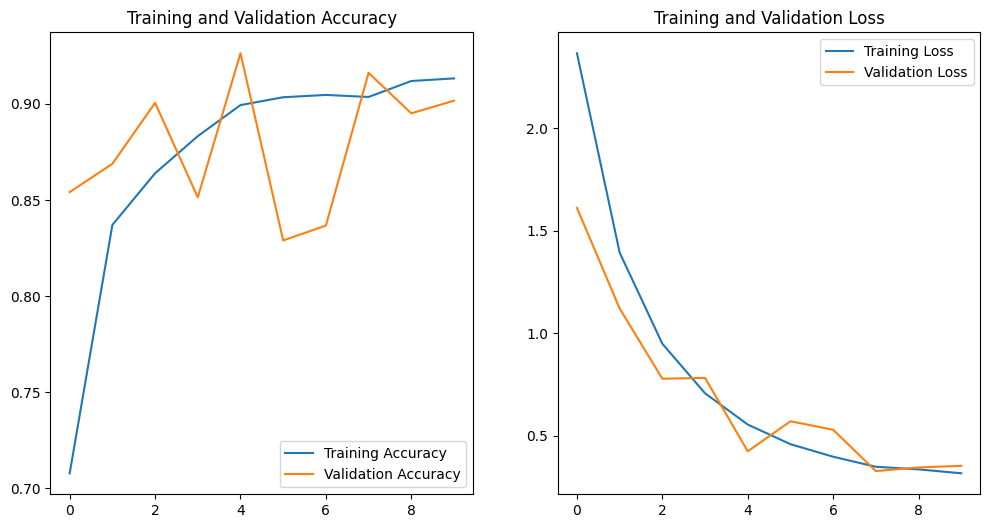

In [8]:
import matplotlib.pyplot as plt

# Plot Accuracy and Loss Graphs
def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))

    # Plot Training and Validation Accuracy
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, label='Training Accuracy')
    plt.plot(epochs, val_acc, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    # Plot Training and Validation Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, label='Training Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    plt.show()

# Call the function to plot
plot_training_history(history)


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━

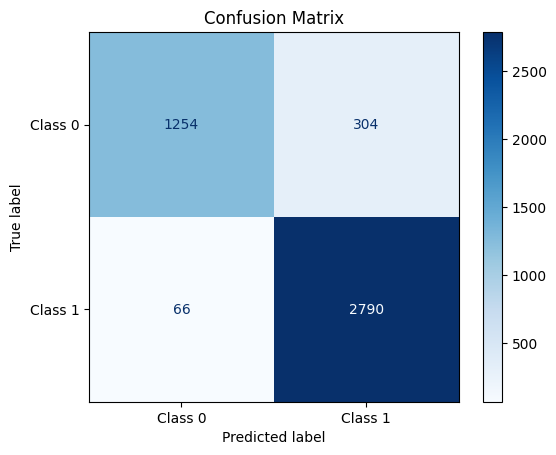

              precision    recall  f1-score   support

     Class 0       0.95      0.80      0.87      1558
     Class 1       0.90      0.98      0.94      2856

    accuracy                           0.92      4414
   macro avg       0.93      0.89      0.90      4414
weighted avg       0.92      0.92      0.91      4414



In [9]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import numpy as np

# Generate predictions on the test dataset
y_true = []
y_pred = []

# Collect true labels and predictions
for images, labels in test_dataset:  # Assuming `test_dataset` is batched
    y_true.extend(labels)  # True labels
    predictions = model.predict(images)  # Predictions
    y_pred.extend((predictions > 0.5).astype(int))  # Convert probabilities to binary (0 or 1)

y_true = np.array(y_true).flatten()  # Flatten to 1D
y_pred = np.array(y_pred).flatten()

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Class 0", "Class 1"])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

# Classification Report
report = classification_report(y_true, y_pred, target_names=["Class 0", "Class 1"])
print(report)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


<ipython-input-11-b0451921fd50>:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  predicted_class = int(prediction[0] > 0.5)  # Assuming binary classification


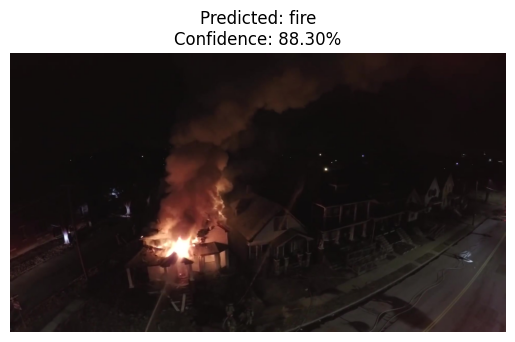

Predicted Class: fire
Confidence Score: 88.30%


In [11]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

def predict_single_image(model, img_path, target_size=(299, 299)): # Change target_size to (299, 299)
    """
    Predicts the class of a single image using the trained model.

    Parameters:
        model: Trained model.
        img_path: Path to the image file.
        target_size: Size to resize the image (default: 299x299 for InceptionV3).

    Returns:
        Predicted class and confidence score.
    """
    # Load the image
    img = image.load_img(img_path, target_size=target_size)

    # Convert the image to a NumPy array
    img_array = image.img_to_array(img)

    # Normalize the image (scale pixel values to [0, 1])
    img_array = img_array / 255.0

    # Add an extra dimension to match the input shape of the model (batch size = 1)
    img_array = np.expand_dims(img_array, axis=0)

    # Make the prediction
    prediction = model.predict(img_array)

    # Output the predicted class and confidence score
    predicted_class = int(prediction[0] > 0.5)  # Assuming binary classification
    confidence_score = prediction[0][0]  # Confidence score for the positive class

    class_names = ["No_fire", "fire"]  # Replace with your actual class names
    return class_names[predicted_class], confidence_score

# Example usage
img_path = '/content/Test_Data/FIRE/00159.jpg'  # Provide the path to your image
predicted_class, confidence_score = predict_single_image(model, img_path)

# Plotting the image along with the predicted class and confidence score
img = image.load_img(img_path)  # Load the image to display it
plt.imshow(img)
plt.axis('off')  # Hide the axes
plt.title(f"Predicted: {predicted_class}\nConfidence: {confidence_score * 100:.2f}%")
plt.show()

print(f"Predicted Class: {predicted_class}")
print(f"Confidence Score: {confidence_score * 100:.2f}%")